In [1]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import itertools

root_dir = Path('~/model_evals').expanduser()

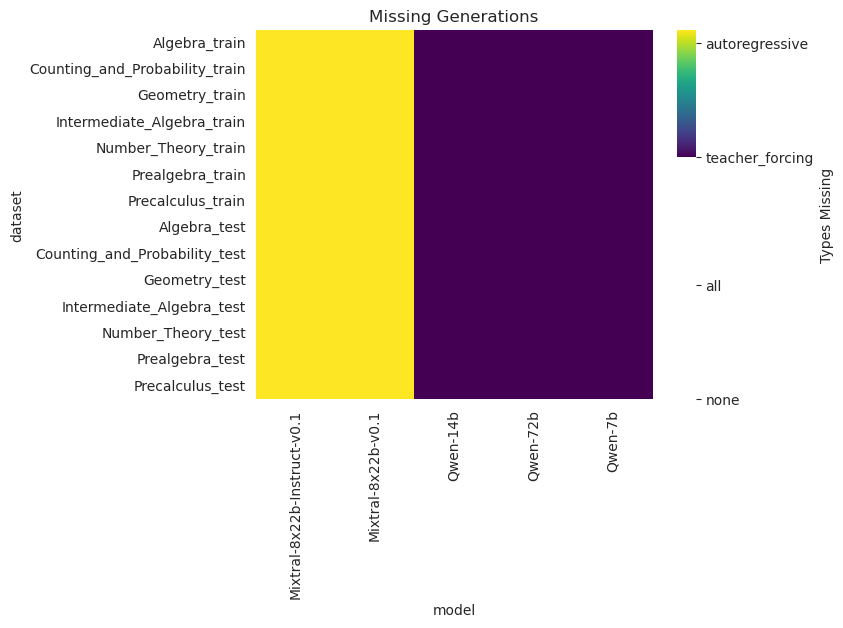

In [3]:
datasets = set(root_dir.iterdir())
models = set(itertools.chain(*[list(dataset.iterdir()) for dataset in datasets]))
models = set(m.name for m in models)

# every dataset should contain directories for each model
# each model should contain directories for each method (teacher_forcing, autoregressive)
# each method should contain output.json and args.json

missing = []
for dataset in datasets:
    for model in models:
        if not (dataset / model).exists():
            missing.append((dataset.name, model, 'all'))
            continue
        for method in ['teacher_forcing', 'autoregressive']:
            if not (dataset / model / method).exists():
                missing.append((dataset.name, model, method))
            elif not (dataset / model / method / 'output.json').exists() or not (dataset / model / method / 'args.json').exists():
                    missing.append((dataset.name, model, method))

# create a dataframe of missing directories
missing = pd.DataFrame(missing, columns=['dataset', 'model', 'method'])
# if there is an instance of 'teacher_forcing' and 'autoregressive' for a dataset and model, replace with 'all'
missing = missing.groupby(['dataset', 'model']).apply(lambda x: 'all' if list(x.method.values) == ['teacher_forcing', 'autoregressive'] else x.method.values[0]).reset_index().rename(columns={0: 'method'})
# make model the columns
missing = missing.pivot(index='dataset', columns='model', values='method')
# sort the datasets to place those ending with _test at the end
missing = missing.reindex(sorted(missing.index, key=lambda x: x.endswith('_test')))
# fill missing values with 'found'
missing = missing.fillna('none')
# plot heatmap
import seaborn as sns
value_map = {'none': 0, 'all': 1, 'teacher_forcing': 2, 'autoregressive': 3}
sns.heatmap(missing.map(lambda x: value_map[x]), cmap='viridis')
# set the color bar to show the values
cbar = plt.gca().collections[0].colorbar
cbar.set_ticks([0.1, 1, 2, 2.9])
cbar.set_ticklabels(['none', 'all', 'teacher_forcing', 'autoregressive'])
# set color bar title to "Type Missing"
cbar.set_label('Types Missing')
plt.title('Missing Generations')
plt.show()

In [7]:
list(missing.columns)

['Abel-7b',
 'Gemma-1.1-7b-Instruct',
 'Gemma-7b-Instruct',
 'LLeMMA-34b',
 'LLeMMA-7b',
 'Mixtral-8x22b-Instruct-v0.1',
 'Mixtral-8x22b-v0.1']

In [ ]:
# # copy teacher_forcing outputs.json and args.json to rootdir
# root_dir_train_tf = Path('~/model_evals/model_evals_train_tf').expanduser()
# for dataset in root_dir_train_tf.iterdir():
#     for model in dataset.iterdir():
#         for method in model.iterdir():
#             if method.name == 'teacher_forcing':
#                 output = method / 'output.json'
#                 args = method / 'args.json'
#                 save_path = root_dir / dataset.name / model.name / 'teacher_forcing'
#                 save_path.mkdir(parents=True, exist_ok=True)
#                 # print(f'Copying\t{output}\nto\t\t{save_path}')
#                 # this might overwrite existing files
#                 output.rename(save_path / 'output.json')
#                 args.rename(save_path / 'args.json')